# CS 584-A Final Project
# Toxic Comment Classification Technique: worst group accuracy optimization
# Non-WGA (Overall Accuracy) Model
### Name: Brian Moon
### CWID: 10468944
### Stevens Institute of Technology
##### I pledge my honor that I have abided by the Stevens Honor System

In [1]:
!pip install -q transformers
!pip uninstall -y datasets
!pip install -q --upgrade huggingface_hub
!pip install -q datasets==2.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

# 1: Import and Process Data



In [3]:
#Import packages
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset
from transformers import(
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import torch
torch.cuda.is_available()


True

In [4]:
#Data directory (Change this depending on file location/machine)
from google.colab import drive
drive = drive.mount('/content/drive')
data_dir = 'drive/MyDrive/kaggle_data'

Mounted at /content/drive


In [15]:
#Load data from given train and val data files
train_x = pd.read_csv(f"{data_dir}/train_x.csv", index_col=0)
train_y = pd.read_csv(f"{data_dir}/train_y.csv")
val_x = pd.read_csv(f"{data_dir}/val_x.csv", index_col=0)
val_y = pd.read_csv(f"{data_dir}/val_y.csv")

In [16]:
#Extract the input string and the binary label, and put it into a dataframe
train_df = pd.DataFrame({
    "text": train_x.iloc[:, 0].astype(str).tolist(),
    "labels": train_y["y"].astype(int).tolist()
})

val_df = pd.DataFrame({
    "text": val_x.iloc[:, 0].astype(str).tolist(),
    "labels": val_y["y"].astype(int).tolist()
})

#Convert those dataframes into a huggingface dataset to use for BERT
train_ds = Dataset.from_pandas(train_df).shuffle(seed=42).select(range(10_000))
val_ds = Dataset.from_pandas(val_df).shuffle(seed=42).select(range(2_000))

In [17]:
#Use BertTokenizer to tokenize our data to use for BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
#Format for PyTorch

train_ds = train_ds.cast_column("labels", datasets.features.Value("float32"))
val_ds = val_ds.cast_column("labels", datasets.features.Value("float32"))

# train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Load Model

In [23]:
#Load model and set the training arguments
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

training_args = TrainingArguments(
    output_dir="./bert-toxic",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_steps=20,
    logging_strategy="steps",
    remove_unused_columns=True
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn.functional as F

class GlobalAccuracyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        #forward pass through model
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()

        #calculate proabability
        probs = torch.sigmoid(logits)

        #calculate cross entropy loss based on probabilities
        bce_loss = F.binary_cross_entropy(probs, labels)

        #use soft global accuracy approximation- better for loss than binary classification
        diff = torch.abs(probs-labels)
        soft_acc = 1.0-diff.mean()

        #combine bce loss with global accuracy penalty
        alpha = 1.0  # You can tune this weight
        loss = bce_loss + alpha * (1.0 - soft_acc)

        #log metrics
        self.log({"train/soft_acc": soft_acc.item()})
        self.log({"train/bce_loss": bce_loss.item()})
        if self.state.global_step%20==0:
          print("train/soft_acc:",soft_acc.item(),"| train/bce_loss:",bce_loss.item())

        return (loss, outputs) if return_outputs else loss


In [25]:
#Set up trainer and train the model
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = GlobalAccuracyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator = data_collator
)


<ipython-input-25-1996f4e637d0>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `GlobalAccuracyTrainer.__init__`. Use `processing_class` instead.
  trainer = GlobalAccuracyTrainer(


In [26]:
trainer.train()


train/soft_acc: 0.42110228538513184 | train/bce_loss: 0.8734383583068848


Step,Training Loss
20,0.680900
40,0.545300
60,0.558700
80,0.498000
100,0.507100
120,0.471400
140,0.427100
160,0.426700
180,0.488800
200,0.409500


train/soft_acc: 0.9274695515632629 | train/bce_loss: 0.07534871995449066
train/soft_acc: 0.7199531197547913 | train/bce_loss: 0.7682434916496277
train/soft_acc: 0.9393765330314636 | train/bce_loss: 0.06261419504880905
train/soft_acc: 0.8581726551055908 | train/bce_loss: 0.25592702627182007
train/soft_acc: 0.9252902865409851 | train/bce_loss: 0.22748586535453796
train/soft_acc: 0.8659771680831909 | train/bce_loss: 0.24746142327785492
train/soft_acc: 0.8755388855934143 | train/bce_loss: 0.16820809245109558
train/soft_acc: 0.8617928624153137 | train/bce_loss: 0.4291311204433441
train/soft_acc: 0.7367042303085327 | train/bce_loss: 0.8869678378105164
train/soft_acc: 0.9275709986686707 | train/bce_loss: 0.2987723648548126
train/soft_acc: 0.8923767805099487 | train/bce_loss: 0.24751964211463928
train/soft_acc: 0.9460411071777344 | train/bce_loss: 0.05978821963071823
train/soft_acc: 0.9267709851264954 | train/bce_loss: 0.09973948448896408
train/soft_acc: 0.8766023516654968 | train/bce_loss: 0.

TrainOutput(global_step=1875, training_loss=0.27562375316619875, metrics={'train_runtime': 2729.7464, 'train_samples_per_second': 10.99, 'train_steps_per_second': 0.687, 'total_flos': 7893260789760000.0, 'train_loss': 0.27562375316619875, 'epoch': 3.0})

In [30]:
trainer.evaluate()

{'eval_loss': 0.45858070254325867,
 'eval_runtime': 59.5357,
 'eval_samples_per_second': 33.593,
 'eval_steps_per_second': 2.1,
 'epoch': 3.0}

In [31]:
#Get predictions for fairness analysis
pred_output = trainer.predict(val_ds)
logits = pred_output.predictions
labels = pred_output.label_ids


In [32]:
from sklearn.metrics import f1_score, accuracy_score
probs = torch.sigmoid(torch.tensor(logits)).numpy()
print(max(probs))
preds = (probs > .5).astype(int).flatten()

acc = accuracy_score(labels,preds)
f1 = f1_score(labels,preds,average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")

[0.9981177]
Accuracy: 0.9110
F1 Macro: 0.7581


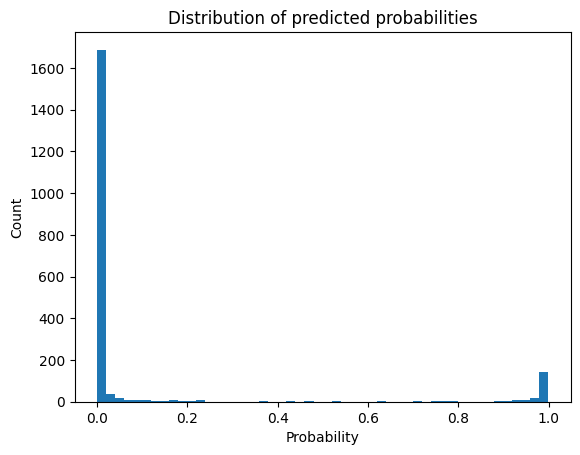

In [33]:
import matplotlib.pyplot as plt

plt.hist(probs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


The distribution suggests a divided split where the probabilities are almost all 0 or 1 without much in between. This suggests potential overfitting, but the acuraccy is high.

Additionally, the primary goal of the experiment is to see if WGA can help prevent false positives, so we want to evaluate: \\
1: how many toxic comments got through this detector? \\
2: how many flagged comments are false positives?

### Undetected toxic comment evaluation:


In [36]:
confidence_mask = probs.flatten() < 0.5
filtered_preds = (probs[confidence_mask] > 0.5)
filtered_labels = labels[confidence_mask]

filtered_acc = accuracy_score(filtered_labels, filtered_preds)
filtered_f1 = f1_score(filtered_labels, filtered_preds, average="macro")
print(f"Accuracy (prob < 0.5): {filtered_acc:.4f}")
print(f"F1 score (prob < 0.5): {filtered_f1:.4f}")


Accuracy (prob < 0.5): 0.9488
F1 score (prob < 0.5): 0.4869


### False positive evaluation:

In [37]:
confidence_mask = probs.flatten() > 0.5
filtered_preds = (probs[confidence_mask] > 0.5)
filtered_labels = labels[confidence_mask]

filtered_acc = accuracy_score(filtered_labels, filtered_preds)
filtered_f1 = f1_score(filtered_labels, filtered_preds, average="macro")
print(f"Accuracy (prob > 0.5): {filtered_acc:.4f}")
print(f"F1 score (prob > 0.5): {filtered_f1:.4f}")


Accuracy (prob > 0.5): 0.5743
F1 score (prob > 0.5): 0.3648


We can see that the predictions that were high probability of being toxic had an accuracy of about 0.57, which means that there were many false positives in the flagged comments. Not many toxic comments were able to go undetected though.

Sample:

In [40]:
import pandas as pd
val_ds_output = Dataset.from_pandas(val_df).shuffle(seed=42).select(range(2_000))

# Choose indices you want to examine
indices = [47,61,67,78,99]
for i in indices:
    print(f"\nSample {i}")
    print("Text:", val_ds_output["text"][i])
    print("Prob:", probs[i])
    print("True Label:", labels[i])
    print("Binary Prediction:", int(probs[i] > 0.5))



Sample 47
Text: So you're the white guy that can call black guys the n word because you have a black friend.
Prob: [0.99181646]
True Label: 0.0
Binary Prediction: 1

Sample 61
Text: white media??????? what are you on about? any criticism is in your eyes, racist. that excuse died 100 years ago.
Prob: [0.09330044]
True Label: 1.0
Binary Prediction: 0

Sample 67
Text: The Trump voters remind me of the "good Germans" too. They would be happy if the rest of us that didn't vote for Trump would just disappear. They would never ask where we disappeared to. The GOP is just a white identity party in the 21st century. They have been endorsed by white supremacists from coast to coast and border to border. They all may not be white racists, however they are all sympathizers with white supremacists.
Prob: [0.0225666]
True Label: 0.0
Binary Prediction: 0

Sample 78
Text: No, Arpaio was found guilty of unConstitutional acts.

Your lame attempt to make it something else is disgustingly wrong both, in 

<ipython-input-40-2881c8c5a5b5>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Binary Prediction:", int(probs[i] > 0.5))
